In [19]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'movie-recommendation-system:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3375918%2F5872805%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240803%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240803T060956Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9e32aca1e961a9b06ef8d076f62422b90ffcd7bd112214da6bd5f348fc5aa0d6ba153bca55559a8aeb398e8753b0ee24084f9f8e0a8a0585969620ca829fa9fc1ee29bd1b1db0d4a71f89343c79234a8d54f9a15873d2eea941f1aa40e0724ebf50efbc6132bfe3b03e8154548396abfab572b302f5eb7119dfb29a5661559917687fe78b37a55677054c870614f081ee2f89002fbf54a452025fc16b7293fdea33cceb6e84170a7c824bdbcdda5bf4aad1ad636260aaf4574f274c0b280d1d53680b42e2e13409dca6d043ce1d587948dabefe233f7a6f02279423499e893e41b63aab2b0e837c3fea2089ab3c9548cb7ed1c29ec0d849ad9b7a03a17c637db'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 172958815 bytes downloaded
Downloaded and uncompressed: movie-recommendation-system
Data source import complete.


# Movie Personal Recommend w/LGBM Ranker

In [20]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
#import lightgbm as lgb
from lightgbm.sklearn import LGBMRanker
import matplotlib.pyplot as plt

In [21]:
df = pd.read_csv('/kaggle/input/movie-recommendation-system/ratings.csv')
display(df[0:3])
n=len(df)
print(n)
N=list(range(n))
random.seed(2024)
random.shuffle(N)
df=df.iloc[N[0:3000]]

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828


25000095


In [22]:
movie=pd.read_csv('/kaggle/input/movie-recommendation-system/movies.csv')
display(movie[0:3])
print(movie.columns.tolist())


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


['movieId', 'title', 'genres']


In [23]:
#anime_id to name mapping
mapping = dict(zip(movie['movieId'], movie['title']))

In [24]:
df=df.merge(movie,on='movieId',how='left')
display(df)

,userId,movieId,rating,timestamp,title,genres
0,14635,590,3.0,843583397,Dances with Wolves (1990),Adventure|Drama|Western
1,162508,47634,2.0,1365194093,36 Quai des Orfèvres (Department 36) (2004),Action|Crime|Drama|Thriller
2,36413,440,3.0,839512088,Dave (1993),Comedy|Romance
3,59973,69306,2.5,1272971505,"Taking of Pelham 1 2 3, The (2009)",Crime|Drama|Thriller
4,50769,141,3.0,1449797467,"Birdcage, The (1996)",Comedy
...,...,...,...,...,...,...
2995,75655,367,4.0,834345062,"Mask, The (1994)",Action|Comedy|Crime|Fantasy
2996,21528,590,4.0,1080222243,Dances with Wolves (1990),Adventure|Drama|Western
2997,46055,2770,4.0,941787655,Bowfinger (1999),Comedy
2998,148738,6754,4.0,1081024320,Underworld (2003),Action|Fantasy|Horror


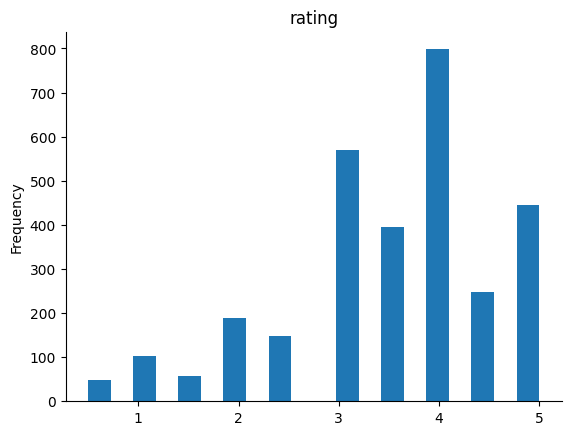

In [27]:
# @title rating

from matplotlib import pyplot as plt
df['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

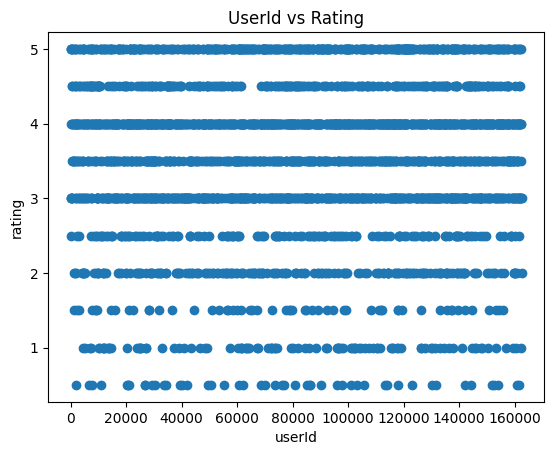

In [25]:
plt.scatter(df['userId'], df['rating'])
plt.xlabel('userId')
plt.ylabel('rating')
plt.title('UserId vs Rating')
plt.show()

In [26]:
df['movieId'].value_counts()

,count
movieId,
2858,14
296,13
2716,12
110,11
593,11
923,10
1732,10
527,8
47,8


In [28]:
print(df['rating'].unique().tolist())
print(df['userId'].nunique())
print(df['movieId'].nunique())

[3.0, 2.0, 2.5, 4.0, 5.0, 3.5, 0.5, 1.5, 4.5, 1.0]
2913
1768


In [29]:
print(df.columns.tolist())

['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres']


In [30]:
feature_cols=['userId', 'movieId']
target= 'rating'    # personal rating data
group_col='userId'  # as only one personal item

In [31]:
dataX=df[feature_cols]
dataY=df[target]

In [32]:
dataY=(dataY*2).astype(int)

In [33]:
trainX, testX, trainY, testY = train_test_split(dataX, dataY, test_size=0.1, random_state=42)

In [34]:
display(trainX)

,userId,movieId
433,101773,1265
1151,103841,97913
73,49127,48385
1536,20925,45499
2709,117594,6664
...,...,...
1638,19463,1587
1095,112483,6213
1130,69646,1261
1294,100789,1961


from matplotlib import pyplot as plt
trainX['userId'].plot(kind='hist', bins=20, title='userId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
trainX['movieId'].plot(kind='hist', bins=20, title='movieId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
trainX.plot(kind='scatter', x='userId', y='movieId', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
trainX['userId'].plot(kind='line', figsize=(8, 4), title='userId')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
trainX['movieId'].plot(kind='line', figsize=(8, 4), title='movieId')
plt.gca().spines[['top', 'right']].set_visible(False)

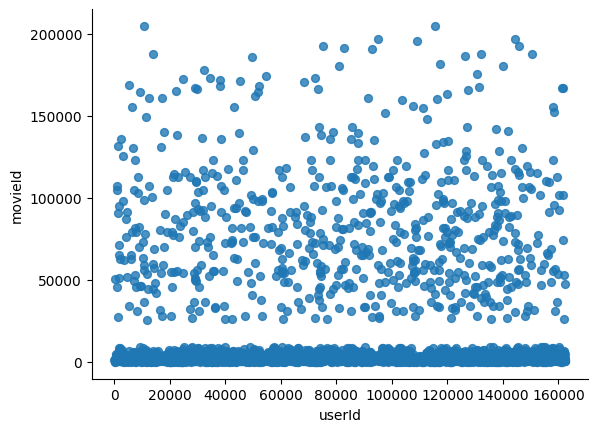

In [35]:
from matplotlib import pyplot as plt
trainX.plot(kind='scatter', x='userId', y='movieId', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [36]:
display(testX)

,userId,movieId
1801,147111,8622
1190,142009,296
1817,45435,367
251,66587,357
2505,4775,1199
...,...,...
2497,160260,1222
787,161561,30816
2636,75469,5653
2538,120516,1967


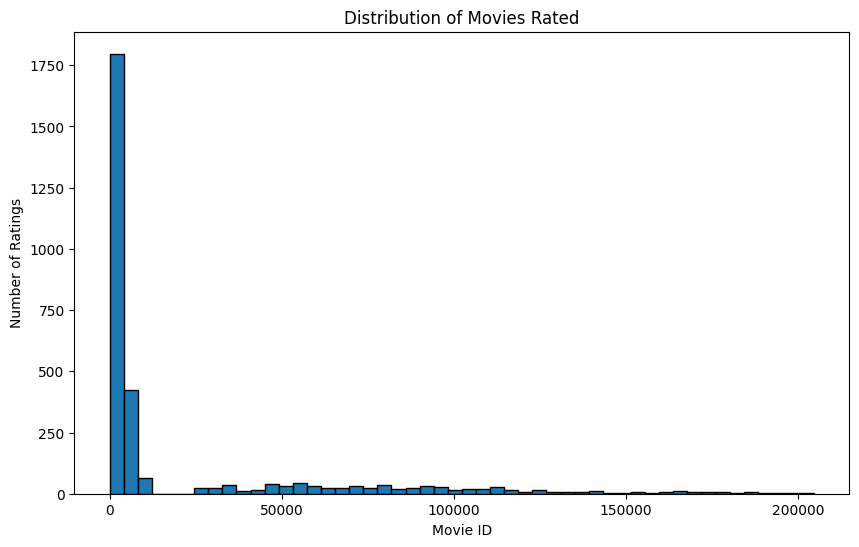

In [38]:
# @title Distribution of Movies Rated

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df['movieId'], bins=50, edgecolor='black')
plt.xlabel('Movie ID')
plt.ylabel('Number of Ratings')
_ = plt.title('Distribution of Movies Rated')

# perepare TESTX to check the recommendation ability of LGBM Ranker  

In [37]:
test_movie=testX['movieId'].value_counts()[0:10].index.tolist()
test_user=testX['userId'].value_counts()[0:10].index.tolist()
print(test_movie)
print(test_user)

[180031, 33794, 296, 592, 5952, 68157, 2716, 7254, 1171, 1270]
[10849, 147111, 142009, 45435, 66587, 4775, 6057, 100007, 120842, 101528]


In [39]:
data=[]
for a in test_movie:
    for u in test_user:
        data+=[[a,u]]

TESTX=pd.DataFrame(data=data,columns=['movieId','userId'])
display(TESTX)
#the combination of 10 users*10 animes

,movieId,userId
0,180031,10849
1,180031,147111
2,180031,142009
3,180031,45435
4,180031,66587
...,...,...
95,1270,4775
96,1270,6057
97,1270,100007
98,1270,120842


from matplotlib import pyplot as plt
TESTX['movieId'].plot(kind='hist', bins=20, title='movieId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
TESTX['userId'].plot(kind='hist', bins=20, title='userId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
TESTX.plot(kind='scatter', x='movieId', y='userId', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
TESTX['movieId'].plot(kind='line', figsize=(8, 4), title='movieId')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
TESTX['userId'].plot(kind='line', figsize=(8, 4), title='userId')
plt.gca().spines[['top', 'right']].set_visible(False)

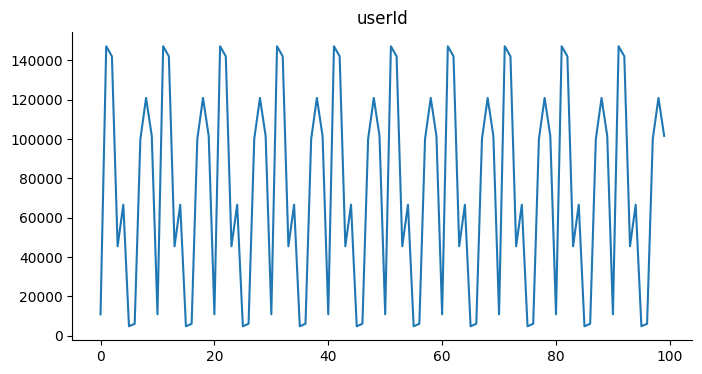

In [41]:
from matplotlib import pyplot as plt
TESTX['userId'].plot(kind='line', figsize=(8, 4), title='userId')
plt.gca().spines[['top', 'right']].set_visible(False)

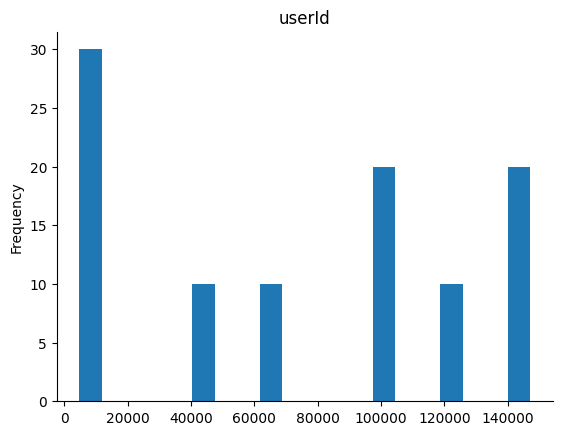

In [40]:
from matplotlib import pyplot as plt
TESTX['userId'].plot(kind='hist', bins=20, title='userId')
plt.gca().spines[['top', 'right',]].set_visible(False)

# LGBMRanker

In [42]:
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=6,
    importance_type='gain',
)

ranker

LGBMRanker(boosting_type='dart', importance_type='gain', metric='ndcg',
           n_estimators=6, objective='lambdarank')

# def get_session_lengths for group

In [43]:
def get_session_lengths(df, group_col):
    return df.groupby(group_col).size().reset_index(name='session_length')

session_lengths_train = get_session_lengths(trainX,group_col)
session_lengths_train[0:5]

,userId,session_length
0,9,1
1,43,1
2,87,1
3,139,1
4,240,1


from matplotlib import pyplot as plt
_df_0['userId'].plot(kind='hist', bins=20, title='userId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['userId']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'userId'}, axis=1)
              .sort_values('userId', ascending=True))
  xs = counted['userId']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('userId', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('userId')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['session_length']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'session_length'}, axis=1)
              .sort_values('session_length', ascending=True))
  xs = counted['session_length']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('session_length', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('session_length')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_3['userId'].plot(kind='line', figsize=(8, 4), title='userId')
plt.gca().spines[['top', 'right']].set_visible(False)

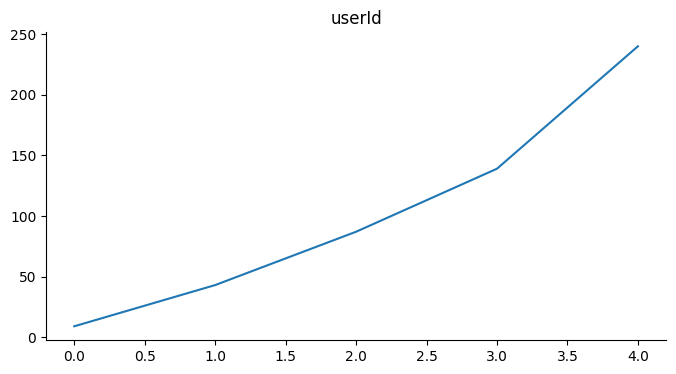

In [44]:
from matplotlib import pyplot as plt
_df_3['userId'].plot(kind='line', figsize=(8, 4), title='userId')
plt.gca().spines[['top', 'right']].set_visible(False)

In [45]:
ranker.fit(
    trainX,
    trainY,
    group=np.array(session_lengths_train['session_length'])
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 2700, number of used features: 2


LGBMRanker(boosting_type='dart', importance_type='gain', metric='ndcg',
           n_estimators=6, objective='lambdarank')

# predict(TESTX)

In [46]:
scores = ranker.predict(TESTX)
scores[0:5]

array([ 0.08228335, -0.95320213, -0.95320213, -0.14612879,  0.88127929])

In [47]:
result=pd.concat([TESTX,pd.DataFrame(data=scores,columns=['score'])],axis=1)
display(result)

,movieId,userId,score
0,180031,10849,0.082283
1,180031,147111,-0.953202
2,180031,142009,-0.953202
3,180031,45435,-0.146129
4,180031,66587,0.881279
...,...,...,...
95,1270,4775,0.188242
96,1270,6057,0.188242
97,1270,100007,0.078410
98,1270,120842,0.524842


from matplotlib import pyplot as plt
result['movieId'].plot(kind='hist', bins=20, title='movieId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
result['userId'].plot(kind='hist', bins=20, title='userId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
result['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
result.plot(kind='scatter', x='movieId', y='userId', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
result.plot(kind='scatter', x='userId', y='score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
result['movieId'].plot(kind='line', figsize=(8, 4), title='movieId')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
result['userId'].plot(kind='line', figsize=(8, 4), title='userId')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
result['score'].plot(kind='line', figsize=(8, 4), title='score')
plt.gca().spines[['top', 'right']].set_visible(False)

In [48]:
for idi in test_movie[0:3]:#selected anime
    dfi=result[result['movieId']==idi]

    dfi=dfi.sort_values('score',ascending=False)
    dfi['title']=dfi['movieId'].map(mapping)
    display(dfi)

,movieId,userId,score,title
4,180031,66587,0.881279,The Shape of Water (2017)
0,180031,10849,0.082283,The Shape of Water (2017)
6,180031,6057,0.082283,The Shape of Water (2017)
5,180031,4775,0.082283,The Shape of Water (2017)
8,180031,120842,0.014694,The Shape of Water (2017)
3,180031,45435,-0.146129,The Shape of Water (2017)
9,180031,101528,-0.706431,The Shape of Water (2017)
7,180031,100007,-0.706431,The Shape of Water (2017)
1,180031,147111,-0.953202,The Shape of Water (2017)
2,180031,142009,-0.953202,The Shape of Water (2017)


,movieId,userId,score,title
14,33794,66587,0.900135,Batman Begins (2005)
18,33794,120842,0.879681,Batman Begins (2005)
17,33794,100007,0.433250,Batman Begins (2005)
19,33794,101528,0.433250,Batman Begins (2005)
13,33794,45435,-0.298230,Batman Begins (2005)
10,33794,10849,-0.298230,Batman Begins (2005)
16,33794,6057,-0.298230,Batman Begins (2005)
15,33794,4775,-0.298282,Batman Begins (2005)
11,33794,147111,-0.590480,Batman Begins (2005)
12,33794,142009,-0.590480,Batman Begins (2005)


,movieId,userId,score,title
24,296,66587,0.545295,Pulp Fiction (1994)
28,296,120842,0.524842,Pulp Fiction (1994)
26,296,6057,0.188242,Pulp Fiction (1994)
20,296,10849,0.188242,Pulp Fiction (1994)
25,296,4775,0.188242,Pulp Fiction (1994)
23,296,45435,0.188242,Pulp Fiction (1994)
29,296,101528,0.078410,Pulp Fiction (1994)
27,296,100007,0.078410,Pulp Fiction (1994)
21,296,147111,-0.945319,Pulp Fiction (1994)
22,296,142009,-0.945319,Pulp Fiction (1994)


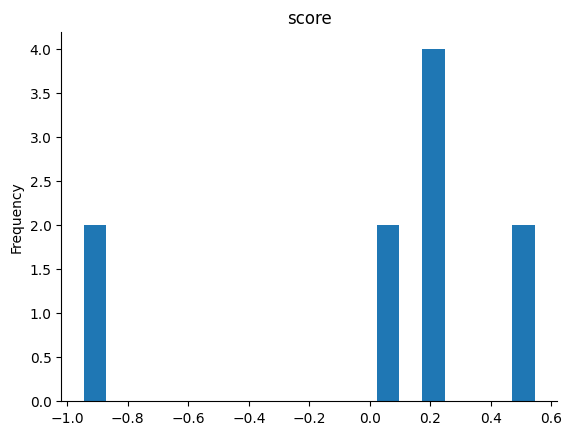

In [49]:
# @title score

from matplotlib import pyplot as plt
dfi['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

## For each movieId, scores are different among userId!!!!

In [50]:
for idi in test_user[0:3]:#selected user
    dfi=result[result['userId']==idi]

    dfi=dfi.sort_values('score',ascending=False)
    dfi['title']=dfi['movieId'].map(mapping)
    display(dfi)

,movieId,userId,score,title
70,7254,10849,0.534312,The Butterfly Effect (2004)
40,5952,10849,0.534312,"Lord of the Rings: The Two Towers, The (2002)"
80,1171,10849,0.188242,Bob Roberts (1992)
60,2716,10849,0.188242,Ghostbusters (a.k.a. Ghost Busters) (1984)
30,592,10849,0.188242,Batman (1989)
20,296,10849,0.188242,Pulp Fiction (1994)
90,1270,10849,0.188242,Back to the Future (1985)
0,180031,10849,0.082283,The Shape of Water (2017)
10,33794,10849,-0.298230,Batman Begins (2005)
50,68157,10849,-0.579614,Inglourious Basterds (2009)


,movieId,userId,score,title
11,33794,147111,-0.590480,Batman Begins (2005)
41,5952,147111,-0.599250,"Lord of the Rings: The Two Towers, The (2002)"
71,7254,147111,-0.599250,The Butterfly Effect (2004)
51,68157,147111,-0.679413,Inglourious Basterds (2009)
21,296,147111,-0.945319,Pulp Fiction (1994)
31,592,147111,-0.945319,Batman (1989)
81,1171,147111,-0.945319,Bob Roberts (1992)
61,2716,147111,-0.945319,Ghostbusters (a.k.a. Ghost Busters) (1984)
91,1270,147111,-0.945319,Back to the Future (1985)
1,180031,147111,-0.953202,The Shape of Water (2017)


,movieId,userId,score,title
12,33794,142009,-0.590480,Batman Begins (2005)
42,5952,142009,-0.599250,"Lord of the Rings: The Two Towers, The (2002)"
72,7254,142009,-0.599250,The Butterfly Effect (2004)
52,68157,142009,-0.679413,Inglourious Basterds (2009)
22,296,142009,-0.945319,Pulp Fiction (1994)
32,592,142009,-0.945319,Batman (1989)
82,1171,142009,-0.945319,Bob Roberts (1992)
62,2716,142009,-0.945319,Ghostbusters (a.k.a. Ghost Busters) (1984)
92,1270,142009,-0.945319,Back to the Future (1985)
2,180031,142009,-0.953202,The Shape of Water (2017)


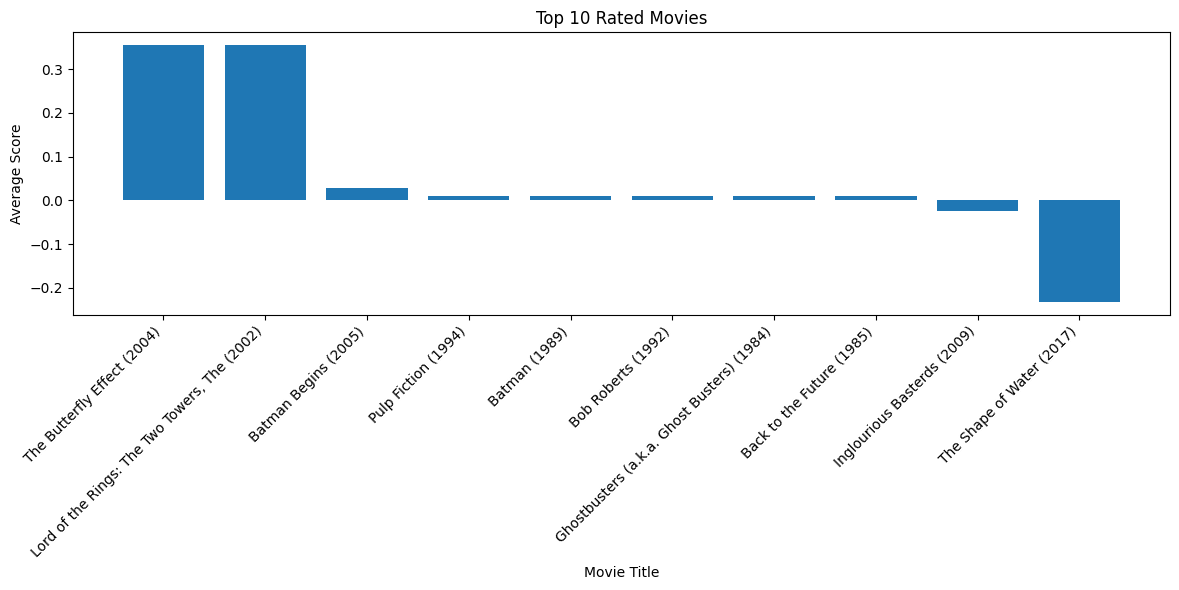

In [52]:
# plot top rated moives and there score, add movie names with respective

import matplotlib.pyplot as plt
# Group the results by movieId and calculate the average score for each movie
average_scores = result.groupby('movieId')['score'].mean().sort_values(ascending=False)

# Get the top 10 rated movies
top_10_movies = average_scores.head(10)

# Map movie IDs to movie titles
top_10_movie_titles = top_10_movies.index.map(mapping)

# Create a bar plot of the top 10 rated movies and their scores
plt.figure(figsize=(12, 6))
plt.bar(top_10_movie_titles, top_10_movies.values)
plt.xlabel('Movie Title')
plt.ylabel('Average Score')
plt.title('Top 10 Rated Movies')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


## Score ranking are different among userId!!!!

# This result shows that LGBM ranker can recommend movie acording to personal favor!!!